# Problem 5.1

In [2]:
import collections
import warnings

# The workhorses
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.optimize
import numdifftools as ndt

# Plotting modules
import matplotlib.pyplot as plt

# MCMC utilities
import emcee

# Numba for JITting log posteriors
import numba

# BE/Bi 103 utilities
import sys
sys.path.append('C:/Users/Elena/Desktop/Caltech/BEBi 103/bebi103_utils')
import bebi103

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Seaborn makes plots look nice
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
sns.set_style('darkgrid', {'axes.facecolor': '(0.875, 0.875, 0.9)'})

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Part A

In [3]:
# Load data
df = pd.read_csv('./data/mean_rest_bouts.csv', comment='#')

# Pull out wild type and mutant and take NaNs to be zero
df = df[df['genotype'].isin(['wt', 'mut'])].fillna(0)
df.head()

,fish,genotype,mean_rest_bout_length
2,FISH11,mut,2.255556
3,FISH12,mut,1.529412
4,FISH13,mut,2.373626
5,FISH14,wt,2.352941
7,FISH18,wt,2.111111


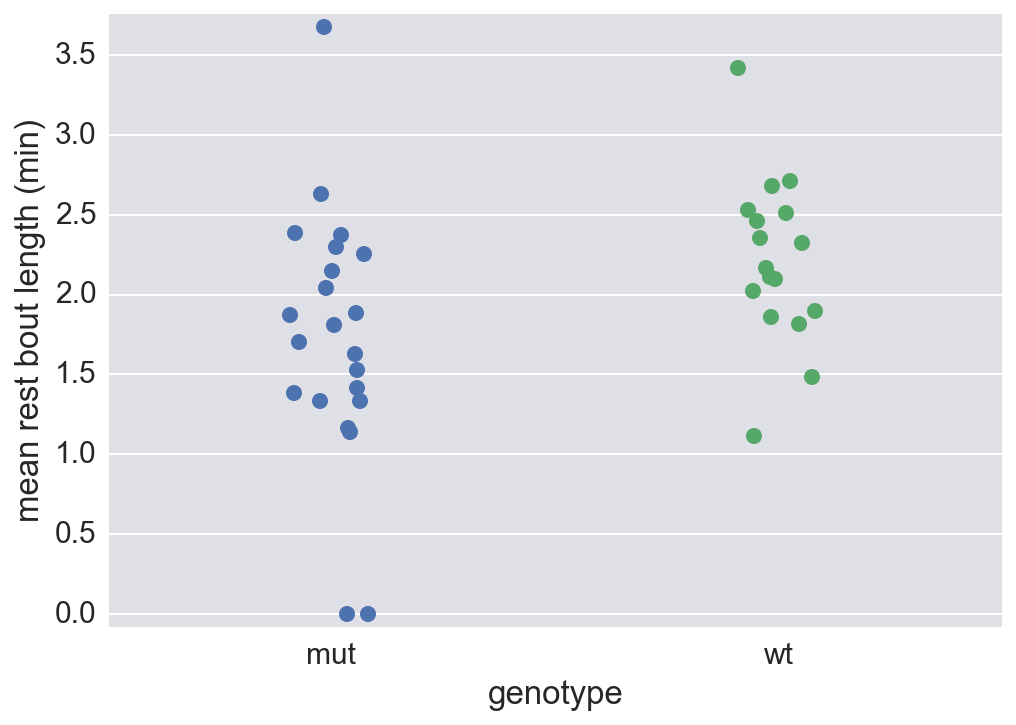

In [4]:
# Make strip plot
sns.stripplot(x='genotype', y='mean_rest_bout_length', data=df, jitter=True)
# Label axes 
plt.ylabel('mean rest bout length (min)')
plt.margins(y=0.02)

In [5]:
#separate the two datasets in to wild type and mutant
wt_fish=df[df["genotype"]=="wt"]
mut_fish=df[df["genotype"]=="mut"]

Sample mean is the best estimate of $\mu$. Unbiased estimator of variance is:
\begin{align}
\frac{n}{n-1}&s^2
\end{align}

In [6]:
#find means for wt and mut
mu_wt = wt_fish.mean()
mu_mut = mut_fish.mean()

#find unbiased estimator of variance for wt and mut
var_wt = wt_fish.var(ddof=1)
var_mut = mut_fish.var(ddof=1)

print("""The best estimates for µ and σ are:
            µ           σ
         -----------------
WT       {0:.4f}     {2:.4f}
Mutant   {1:.4f}     {3:.4f}
""".format(float(mu_wt), float(mu_mut), 
           float(np.sqrt(var_wt)), float(np.sqrt(var_mut))))

The best estimates for µ and σ are:
            µ           σ
         -----------------
WT       2.2094     0.5229
Mutant   1.7271     0.8051



# Part B

Frequentist estimate of the difference of the means:
\begin{align}
\delta \equiv \mu_{wt} - \mu_{mut}
\end{align}

In [8]:
def gaussian_draw(WTmu, WTsigma, MUTmu, MUTsigma, WTreps, MUTreps, trials):
    """
    
    """
    difference_mean_holder=np.empty(trials)
    
    for i in range(trials):
        wt_rep_mean = np.random.normal(WTmu, WTsigma, WTreps).mean()
        mut_rep_mean = np.random.normal(MUTmu, MUTsigma, MUTreps).mean()
        difference_mean_holder[i]=wt_rep_mean - mut_rep_mean
        
    return difference_mean_holder


In [9]:
difference_out = gaussian_draw(mu_wt, np.sqrt(var_wt),mu_mut, 
                               np.sqrt(var_mut), len(wt_fish), 
                               len(mut_fish), 10000)

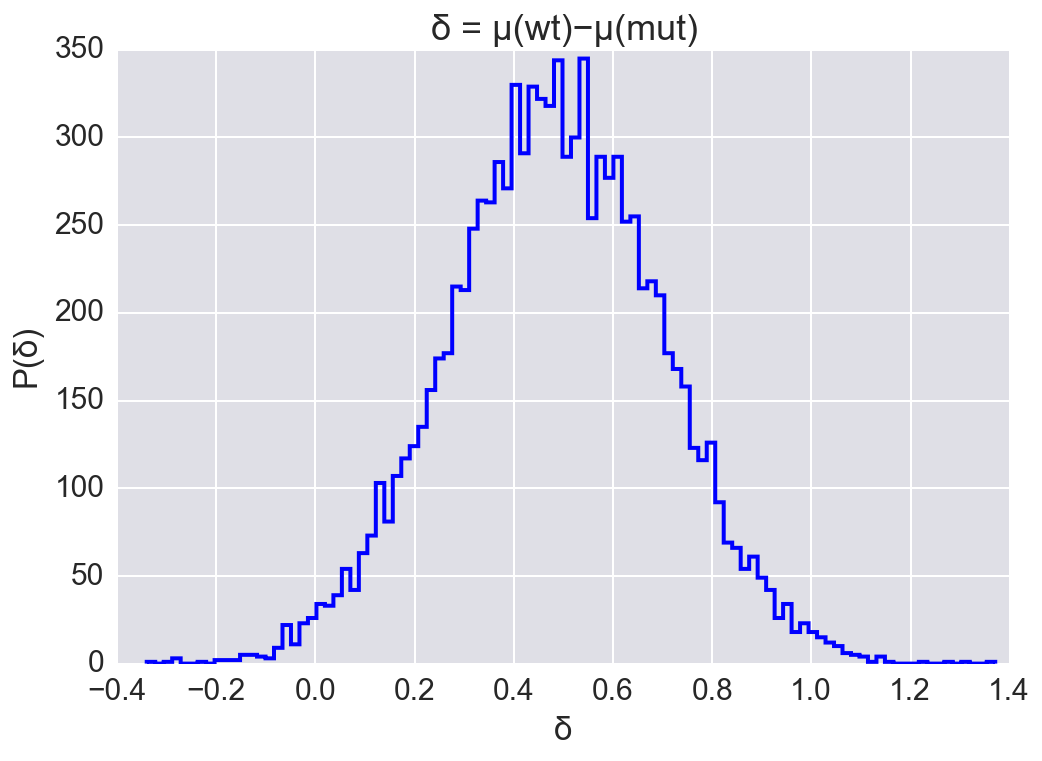

In [10]:
plt.hist(difference_out, histtype="step", bins=100, color="blue", lw=2)
conf_interval = np.percentile(difference_out, (2.5,97.5))
plt.xlabel("δ")
plt.ylabel("P(δ)")
plt.title("δ = μ(wt)−μ(mut)")

In [11]:
print ("The 95% confidence interval is", conf_interval, "minutes")
print("""The final result is:
      µ(wt)-µ(mut) = {0:.4f} ± {1:.4f}"""
      .format(float(mu_wt-mu_mut), float(1.96*np.std(difference_out))), "minutes")

The 95% confidence interval is [ 0.06252408  0.89923602] minutes
The final result is:
      µ(wt)-µ(mut) = 0.4823 ± 0.4164 minutes


# Part C

In [17]:
#this code has been modified from previous HW solutions.

# Define log of the posterior
def log_post(p, x_wt, x_mut):
    """
    Returns the log of the posterior consisting of the product of Gaussians.
    p[0] = mu_wt
    p[1] = mu_mut
    p[2] = sigma_wt
    p[3] = sigma_mut
    """
    # Unpack parameters
    mu_wt, mu_mut, sigma_wt, sigma_mut = p
    
    # Make sure we have everything in the right range
    if (sigma_wt < 0) or (sigma_mut < 0):
        return -np.inf

    # Compute separate parts of posterior from each sample
    log_post_wt = st.norm.logpdf(x_wt, mu_wt, sigma_wt).sum() - np.log(sigma_wt)
    
    log_post_mut = st.norm.logpdf(x_mut, mu_mut, sigma_mut).sum() - np.log(sigma_mut)

    # Add them up to return
    return log_post_wt + log_post_mut

def negative_log_post(p, x_wt,x_mut):
    return -log_post(p,x_wt,x_mut)

#MAP
wt=wt_fish[("mean_rest_bout_length")]
mut=mut_fish[("mean_rest_bout_length")]
args = (wt,mut)

p0 = np.array([ 2, 1.5, 0.5, 0.8])

hes_fun = ndt.Hessian(log_post)
res = scipy.optimize.minimize(negative_log_post, p0, args=args)
hes = hes_fun(res.x,wt,mut)
cov1 = -np.linalg.inv(hes)

bayesian_estimate_diff = res.x[0]-res.x[1]
credible_interval = 1.96 * np.sqrt(np.sqrt(cov1[0,0])**2 + np.sqrt(cov1[1,1])**2)

print("The bayesian estimate of the difference of the mean is", 
      bayesian_estimate_diff, "±", credible_interval)

The bayesian estimate of the difference of the mean is 0.482335452396 ± 0.397809846791


# Part E

In [18]:
# Define log of the posterior for H_0 
def log_post_H0(p, x):
    """
    Returns the log of the posterior for a Gaussian.
    p[0] = mu
    p[1] = sigma
    """
    # Unpack parameters
    mu, sigma = p
    
    # Make sure we have everything in the right range
    if (sigma < 0):
        return -np.inf

    # Add them up to return
    return st.norm.logpdf(x, mu, sigma).sum() - np.log(sigma)

In [19]:
# Instantiate Hessian for log posterior for H_0
hes_fun = ndt.Hessian(log_post_H0)

# Compute Hessian at MAP for H_0
hes = hes_fun(np.asarray([df['mean_rest_bout_length'].mean(), 
                          df['mean_rest_bout_length'].std()]), df['mean_rest_bout_length'])

# Calculate covariance matrix for H_0
cov0 = -np.linalg.inv(hes)

In [20]:
# Calculate the log of the good fit ratio
log_good_fit_ratio = \
st.norm.logpdf(df['mean_rest_bout_length'], df['mean_rest_bout_length'].mean(), df['mean_rest_bout_length'].std()).sum() \
- st.norm.logpdf(wt, res.x[0], res.x[2]).sum() \
- st.norm.logpdf(mut, res.x[1], res.x[3]).sum()

# Caclulate the log of the Occam factor
log_occam = np.log(res.x[2]) + np.log(res.x[3]) + np.log(2 * np.pi) + np.log(np.linalg.det(cov0))/2 \
- np.log(df['mean_rest_bout_length'].std()) - 2 * np.log(2 * np.pi) - np.log(np.linalg.det(cov1))/2

# Calculate and print the odds ratio
print("""Odds ratio = {0:.4f}""".format(np.exp(log_good_fit_ratio + log_occam)))

Odds ratio = 0.0830
